In [1]:
## Chapter 8: Tree-Based Methods - Applied Exercises

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (
    DecisionTreeClassifier as DTC,
    DecisionTreeRegressor as DTR,
    plot_tree,
    export_text
)
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (
    RandomForestRegressor as RF,
    GradientBoostingRegressor as GBR
)
from ISLP.bart import BART

Create a plot displaying the test error resulting from random forests on the `Boston` dataset for a more comprehensive range of values for `max_features` and `n_estimators`. Describe the results obtained.

In [2]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [12]:
n_features = len(feature_names)

In [3]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(
     X,                           
     Boston['medv'],
     test_size=0.3,
     random_state=0
)

In [ ]:
max_features = [n_features, n_features/2, np.round(np.sqrt(n_features))]

# Initialize variables to store test errors for each max_features value
test_errors = [[] for _ in max_features]

# Loop through max_features values
for i, max_feat in enumerate(max_features):
    for n_est in range(1, 501):
        # Create and train the Random Forest model
        RF_boston = RF(
            max_features=max_feat,
            n_estimators=n_est,
            random_state=0
        )
        RF_boston.fit(X_train, y_train)
        
        # Predict on the test set
        y_hat_RF = RF_boston.predict(X_test)
        
        # Calculate the test error (MSE)
        test_error = np.mean((y_test - y_hat_RF)**2)
        
        # Append the test error to the respective max_features list
        test_errors[i].append(test_error)

In [ ]:
# Plot the test errors for each max_features value
for i, max_feat in enumerate(max_features):
    plt.plot(range(501), test_errors[i], label=f"max_features={max_feat}")

plt.xlabel("Number of Trees")
plt.ylabel("Test Error (MSE)")
plt.title("Test Error vs. Number of Trees for Different max_features Values")
plt.legend()
plt.grid(True)
plt.show()

In the lab, a classification tree was applied to the `Carseats` data set after converting `Sales` into a qualitative response variable. Now we will predict `Sales` using regression trees and related approaches, treating the response as a quantitative variable.

Split the dataset into a training set and a test set:

In [33]:
Carseats = load_data('Carseats')

model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
n_features = len(feature_names)
X = np.asarray(D)
y = Carseats.Sales

(X_train,
X_test,
y_train,
y_test) = skm.train_test_split(
    X,
    y,
    test_size=0.5,
    random_state=0
)

Fit a regression tree to the training set. Plot the tree, and interpret the results.

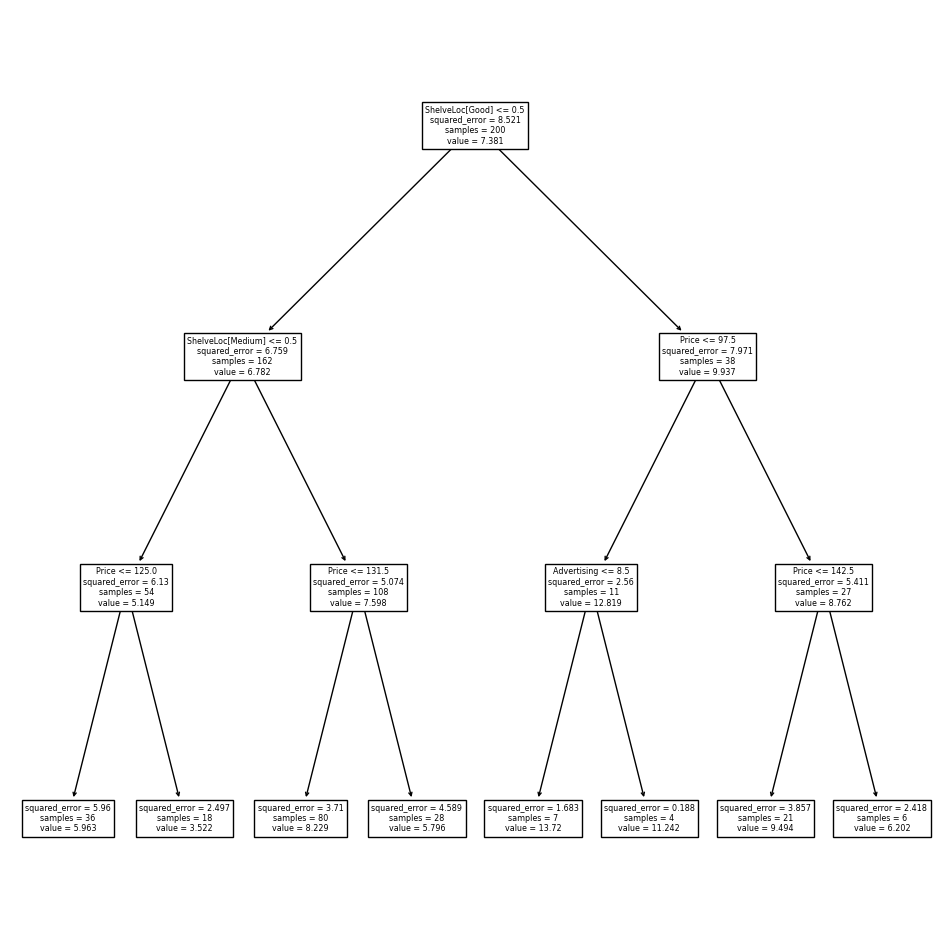

In [23]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(
    reg,
    feature_names=feature_names,
    ax=ax
);

We see that `ShelveLoc` is the most important predictor. Carseats with a good shelf location, a price of less than $97.5 and advertising of less than 8.5 experience the highest value for sales.

In [25]:
y_hat = reg.predict(X_test)
np.mean((y_test - y_hat)**2)

4.991312980450681

We obtain a MSE of 4.99.

Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

In [26]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(
    5,
    shuffle=True,
    random_state=10
)
grid = skm.GridSearchCV(
    reg,
    {'ccp_alpha': ccp_path.ccp_alphas},
    refit=True,
    cv=kfold,
    scoring='neg_mean_squared_error'
)
G = grid.fit(X_train, y_train)

In [27]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

5.135962709248461

Pruning the tree leads to a small increase in MSE.

Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the `feature_importance_` values to determine which variables are most important.

In [28]:
bag_carseats = RF(max_features=X_train.shape[1], random_state=0)
bag_carseats.fit(X_train, y_train)

RandomForestRegressor(max_features=11, random_state=0)

In [29]:
y_hat_bag = bag_carseats.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

2.8094959430999973

The bagging MSE is about 2.81, almost half of that of the optimal pruned tree.

Use random forests to analyze this data. What test MSE do you obtain? Use the feature_importance_ values to determine which variables are most important. Describe the efect of m, the number of variables considered at each split, on the error rate obtained.

In [42]:
max_features = [n_features, int(np.round(n_features/2)), int(np.round(np.sqrt(n_features)))]

for _, features in enumerate(max_features):
    RF_carseats = RF(
        max_features=features,
        random_state=0
    ).fit(X_train, y_train)

    y_hat_RF = RF_carseats.predict(X_test)
    MSE = np.mean((y_test - y_hat_RF)**2)
    print(f'Features: {features}, MSE: {MSE}')

Features: 11, MSE: 2.8094959430999973
Features: 6, MSE: 2.740467705149998
Features: 3, MSE: 2.881336310649998


In [43]:
feature_imp = pd.DataFrame(
    {'importance':RF_carseats.feature_importances_},
    index=feature_names
)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.272669
Age,0.133993
ShelveLoc[Good],0.117024
CompPrice,0.093677
Income,0.087846
Population,0.083581
Advertising,0.076881
Education,0.055564
ShelveLoc[Medium],0.050073
US[Yes],0.015794


We see that the MSE dips when we perform random forest with a maximum of 6 features per estimator. `Price` appears to be the most important variable in determining `Sales`.

This problem involves the OJ data set which is part of the ISLP package.

Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

Fit a tree to the training data, with `Purchase` as the response and the other variables as predictors. What is the training error rate?

In [75]:
OJ = load_data('OJ')
OJ['Store7'] = np.where(OJ['Store7'] == 'Yes', 1, 0) # Convert from string to binary
model = MS(OJ.columns.drop('Purchase'), intercept=False)
D = model.fit_transform(OJ)
feature_names = list(D.columns)
X = np.asarray(D)
y = OJ['Purchase']

In [76]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(
     X,                           
     y,
     test_size=X.shape[0] - 800,
     random_state=0
)

In [84]:
clf = DTC(
    criterion='entropy',
    max_depth=3,
    random_state=0
)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [85]:
accuracy_score(y, clf.predict(X))

0.819626168224299

The training error rate is about 18%.

Create a plot of the tree, and interpret the results. How many terminal nodes does the tree have?

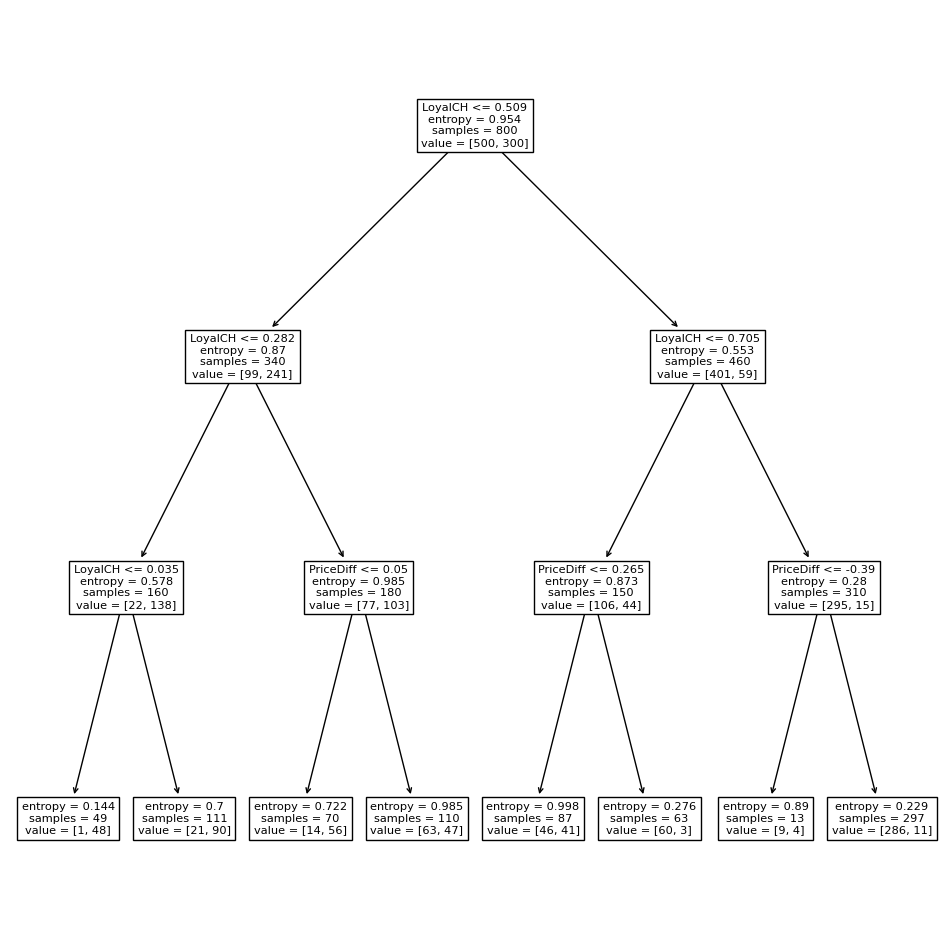

In [86]:
ax = subplots(figsize=(12,12))[1]
plot_tree(
    clf,
    feature_names=feature_names,
    ax=ax
);

Because we set `max_depth=3`, the tree has 8 terminal nodes. 

`LoyaltyCH` is the most important predictor, followed by `PriceDiff`.

Use the export_tree() function to produce a text summary of the ftted tree. Pick one of the terminal nodes, and interpret the information displayed.

In [88]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- LoyalCH <= 0.51
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.04
|   |   |   |--- weights: [1.00, 48.00] class: MM
|   |   |--- LoyalCH >  0.04
|   |   |   |--- weights: [21.00, 90.00] class: MM
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.05
|   |   |   |--- weights: [14.00, 56.00] class: MM
|   |   |--- PriceDiff >  0.05
|   |   |   |--- weights: [63.00, 47.00] class: CH
|--- LoyalCH >  0.51
|   |--- LoyalCH <= 0.71
|   |   |--- PriceDiff <= 0.27
|   |   |   |--- weights: [46.00, 41.00] class: CH
|   |   |--- PriceDiff >  0.27
|   |   |   |--- weights: [60.00, 3.00] class: CH
|   |--- LoyalCH >  0.71
|   |   |--- PriceDiff <= -0.39
|   |   |   |--- weights: [9.00, 4.00] class: CH
|   |   |--- PriceDiff >  -0.39
|   |   |   |--- weights: [286.00, 11.00] class: CH



The first terminal node is the simplest to interpret: For `LocalCH` of less than 0.04, Purchase is most likely to be `MM`.